# Определение возраста покупателей сетевого супермаркета «Хлеб-Соль»

**Описание проекта**: Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования**: Построить модель машинного обучения, которая по фотографии определит приблизительный возраст человека. 

**Ход исследования:**

- *Шаг 1.* Подготовка и загрузка данных.
- *Шаг 2.* Исследовательский анализ данных.
- *Шаг 2.* Обучение модели.
- *Шаг 3.* Анализ модели и выводы.

**Общий вывод**: По итогам проведенного анализа и разработки модели машинного обучения появится возможность определять приблизительный возраст покупателя супермаркета для контроля продажи алкоголя и разработки рекомендательных систем. 

**Описание данных**
Набор фотографий людей с указанием возраста имеет следующие признаки:
- `file_name` — название файла фотографии.
- `real_age` — реальный возраст человека на фотографии (целевой признак).

## Подготовка и загрузка данных

### Импортирование библиотек

In [1]:
# Импортируем библиотеки, которые понадобятся для работы над проектом. 

# для датафрейма 
import pandas as pd
import numpy as np

# для визуализации 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# для модели
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных 

In [2]:
# Считаем данные из csv-файла в датафрейм и сохраним в переменную. 

try:
    data = pd.read_csv('/datasets/faces/labels.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/faces/labels.csv')

In [3]:
# Функция вывода основной информации о файлах-датафреймах

def main_info(df):
    # Информация о структуре датафрейма
    print("Информация о структурах:")
    df.info()
    print("\n")
    display(df.shape)
    print('-----')
    
    # Статистическое описание колонок
    print("Статистика:")
    display(df.describe().T)
    print("\n")
    print('-----')
    
    # Первые десять строк датафрейма
    print("Первые строки:")
    display(df.head(10))
    print("\n")
    print('-----')
    
    # Информация о дубликатах
    print("Количество явных дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print("\n")
    print('-----')
    
    # Информация о пропусках
    print("Количество пропусков в датафрейме:")
    display(df.isna().sum())
    print("\n")
    print('-----')

In [4]:
main_info(data)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB




(7591, 2)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0




-----
Первые строки:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


file_name    0
real_age     0
dtype: int64



-----


In [5]:
# Загрузка фотографий 

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Выводы**

Датасет из файла `labels.csv` мы сохранили в переменную `data`. Он содержит 7591 строку и 2 столбца. Пропусков в данных нет. Названия столбцов соответствуют правилам snake_case. На первый взгляд данные выглядят нормально, но смущает максимальный возраст в 100 лет, необходимо посмотреть такие фотографии отдельно.
Фотографии также были загружены с помощью метода ImageDataGenerator. Количество фотографий соответствует количеству строк в датафрейме.

## Исследовательский анализ данных

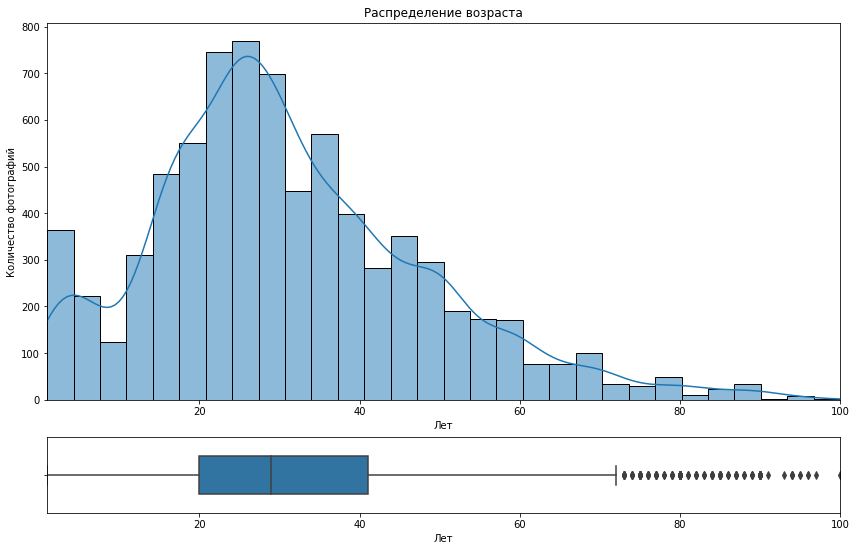

In [6]:
# Построим гистограмму и диаграмму размаха для возраста на одном графике.

fig, ax_hist = plt.subplots(figsize=(12, 8))  # Одна фигура и одна ось

# Гистограмма
sns.histplot(data=data, x="real_age", ax=ax_hist, bins=30, kde=True)
ax_hist.set_title("Распределение возраста")
ax_hist.set_xlabel("Лет")
ax_hist.set_ylabel("Количество фотографий")

# Добавляем box-plot ниже гистограммы
ax_box = ax_hist.inset_axes([0, -0.3, 1, 0.2])  # Устанавливаем положение бокс-плота снизу
sns.boxplot(x=data["real_age"], orient='h', ax=ax_box, width=0.5)
ax_box.set_xlabel("Лет")  # Подпись оси X
ax_box.set_ylabel("")     # Убираем подпись оси Y

# Синхронизируем оси X
x_min = data["real_age"].min()
x_max = data["real_age"].max()
ax_hist.set_xlim(x_min, x_max)
ax_box.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

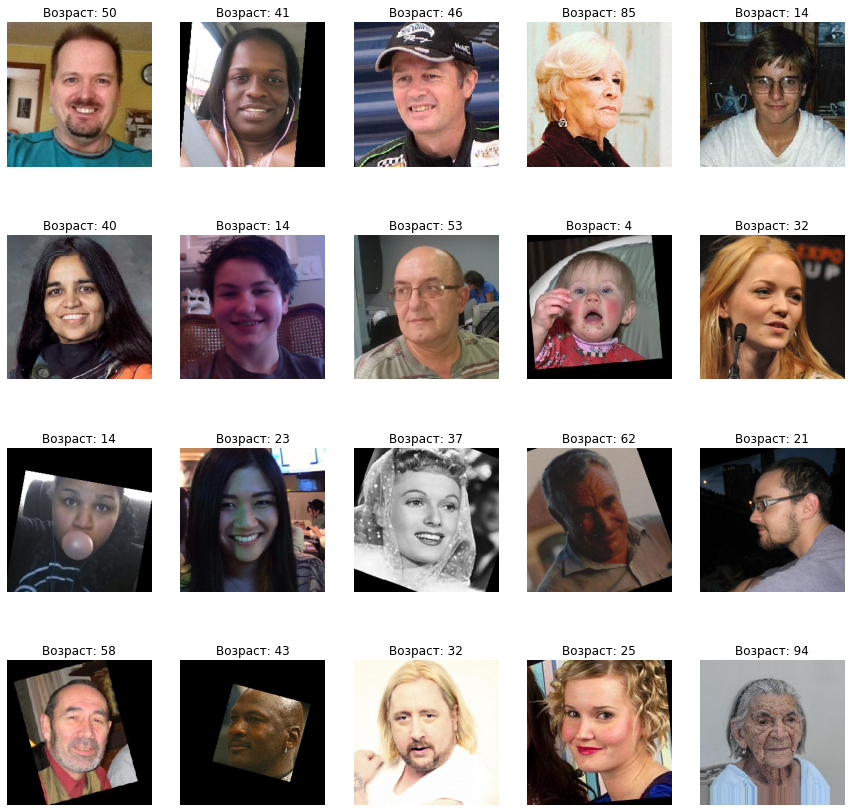

In [7]:
# Выведем несколько фотографий с подписью реального возраста

images, labels = next(train_gen_flow)

plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {labels[i]}')
    plt.axis('off')

plt.show()

(34, 2)
Found 34 validated image filenames.


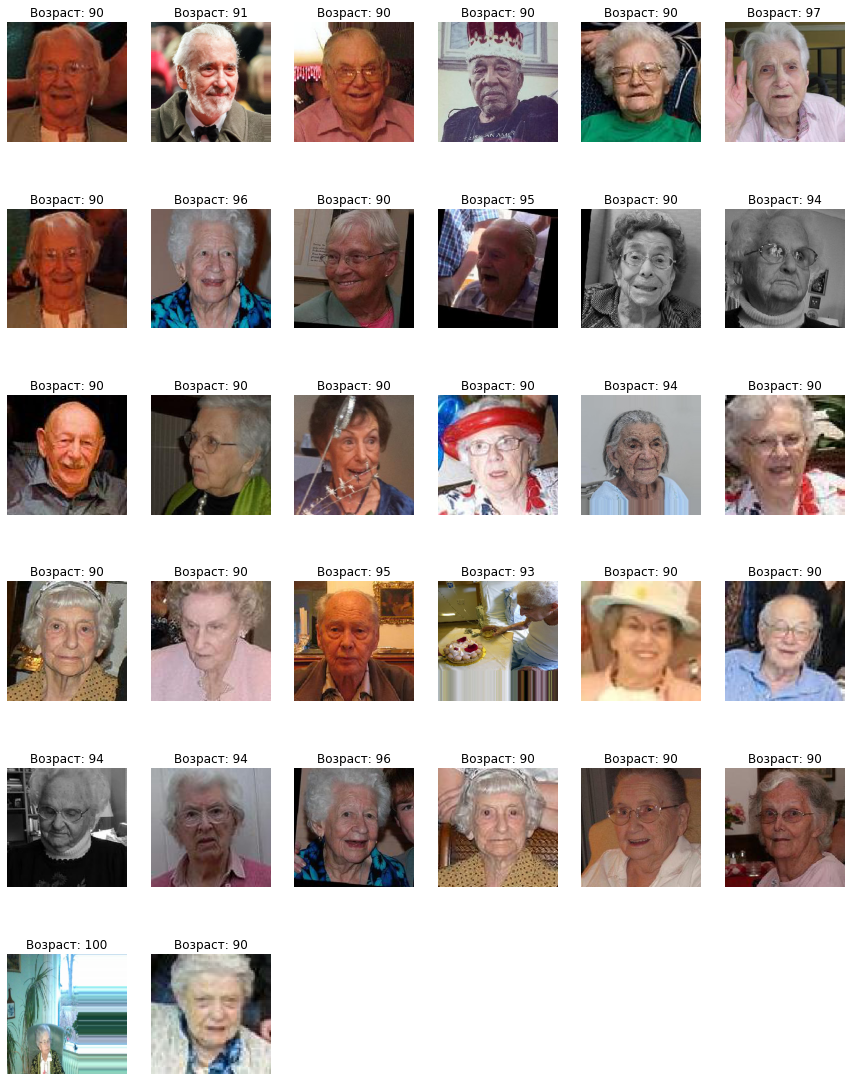

In [8]:
# Изучим фотографии людей старше 90 лет 

over_90 = data[data['real_age'] >= 90]
print(over_90.shape)

# Загрузка фотографий 

over_90_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=over_90,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

# Выведем фотографии

images_over_90, labels_over_90 = next(over_90_gen_flow)

batch_size = len(images_over_90)

plt.figure(figsize=(15, 20))
for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images_over_90[i])
    plt.title(f'Возраст: {labels_over_90[i]}')
    plt.axis('off')

plt.show()

**Выводы**

В настоящем разделе мы провели исследовательский анализ данных, по результатам которого можно сделать следующие выводы:
- Данные распределены нормально от 1 до 100 лет с небольшим пиком ближе к нулю. Вершина «колокола» нормального распределения смещена влево. Пик расположен на значении возраста в 25-30 лет. Медиана приходится на возраст 29 лет, а среднее значение немного больше - 31 год. Наибольшее количество людей в выборке от 20 до 40 лет, дальше с ростом возраста, количество людей, соответствующих этому возрасту, уменьшается.
- Датасет содержит файлы фотографий множества людей разного возраста и пола, выполненных в разных условиях осещения и с разным фоном. Некоторые фотографии в недостаточно хорошем качестве (слишком тёмные, лицо человека повернуто, размазанные, люди гримасничают и пр.).
- В целом проанализированные фотографии из датасета размечены верно и приблизительно соответствуют возрасту, указанному в датафрейме. Хотя при этом некоторые люди выглядят моложе или, наоборот, старше своих лет, но это их индивидуальные особенности.
- Людей старше 90 лет немного, а человек в возрасте 100 лет всего один, его фотография в плохом качестве.

Вероятнее всего фотографии в плохом качестве могут влиять на обучение, так как лицо человека может выглядеть по-разному в зависимости от угла обзора и ориентации, что может привести к неправильному восприятию ключевых черт, таких как линии подбородка, морщины и других признаки возраста. Неравномерное распределение количества объектов между разными возрастами также может влиять на вероятности их предсказания. Будем учитывать вышеописанные особенности данных при моделировании и подборе параметров. 

## Обучение модели

*(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)*

```python

# Функция подготовки тренировочных данных

def load_train(path):
   
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = [.8, .8],
    rotation_range=50,
    width_shift_range=30,
    height_shift_range=20,
    validation_split=.25
    )
       
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'), 
    directory=path + 'final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)

    return train_datagen_flow

# Функция подготовки тестовых данных

def load_test(path):

    test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv') ,
    directory=path + 'final_files/', 
    x_col='file_name',
    y_col='real_age', 
    target_size=(224, 224),
    class_mode='raw',
    subset='validation',
    seed=12345)

    return test_datagen_flow


# Функция создания модели 

def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
              optimizer=optimizer, metrics=['mae'])
    model.summary()

    return model

# Функция обучения модели 
    
def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________

Train for 356 steps, validate for 60 steps
Epoch 1/7
356/356 - 104s - loss: 273.2517 - mae: 12.2500 - val_loss: 375.2240 - val_mae: 14.4782
Epoch 2/7
356/356 - 95s - loss: 142.7007 - mae: 9.1118 - val_loss: 176.8581 - val_mae: 10.3388
Epoch 3/7
356/356 - 100s - loss: 126.3169 - mae: 8.5182 - val_loss: 124.9215 - val_mae: 8.6730
Epoch 4/7
356/356 - 104s - loss: 112.2259 - mae: 8.0367 - val_loss: 104.5209 - val_mae: 7.8345
Epoch 5/7
356/356 - 104s - loss: 107.3878 - mae: 7.9301 - val_loss: 211.0571 - val_mae: 10.9564
Epoch 6/7
356/356 - 102s - loss: 101.6505 - mae: 7.6794 - val_loss: 98.7026 - val_mae: 7.6251
Epoch 7/7
356/356 - 102s - loss: 93.1366 - mae: 7.3561 - val_loss: 108.0194 - val_mae: 7.8056

60/60 - 11s - loss: 108.0194 - mae: 7.8056

```

## Анализ обученной модели и выводы

Для настоящего проекта нам были предоставлены данные сетевого супермаркета «Хлеб-Соль», который внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования**: Построить модель машинного обучения, которая по фотографии определит приблизительный возраст человека. 

В **первом разделе** проекта мы загрузили данные и изучили общую информацию о них. Нам для анализа был предоставлен набор фотографий людей с указанием возраста, который имеет следующие признаки:
- `file_name` — название файла фотографии.
- `real_age` — реальный возраст человека на фотографии (целевой признак).

Датасет содержит 7591 строку и 2 столбца. Пропусков в данных нет. Фотографии также были загружены с помощью метода ImageDataGenerator. Количество фотографий соответствует количеству строк в датафрейме.

Во **втором разделе** мы провели исследовательский анализ данных, по результатам которого можно сделать следующие выводы:
- Данные распределены нормально от 1 до 100 лет с небольшим пиком ближе к нулю. Вершина «колокола» нормального распределения смещена влево. Пик расположен на значении возраста в 25-30 лет. Медиана приходится на возраст 29 лет, а среднее значение немного больше - 31 год. Наибольшее количество людей в выборке от 20 до 40 лет, дальше с увеличением возраста количество людей, соответствующих этому возрасту, уменьшается.
- Датасет содержит файлы фотографий множества людей разного возраста и пола, выполненных в разных условиях осещения и с разным фоном. Некоторые фотографии в недостаточно хорошем качестве (слишком тёмные, лицо человека повернуто, размазанные, люди гримасничают и пр.).
- В целом проанализированные фотографии из датасета размечены верно и приблизительно соответствуют возрасту, указанному в датафрейме. Хотя при этом некоторые люди выглядят моложе или, наоборот, старше своих лет, но это их индивидуальные особенности.
- Людей старше 90 лет немного, а человек в возрасте 100 лет всего один, его фотография в плохом качестве.

В **третьем разделе** мы загрузили данные для обучающей и тестовой выборок с использованием метода ImageDataGenerator. Была обучена модель нейросети со структурой ResNet на GPU с валидационными данными, решающая задачу регрессии - предсказания возвраста по фотографии. Работа модели успешна - метрика MAE 7.8 , по условию задачи она должна быть меньше 8. Так как «MAE» измеряется в абсолютных величинах, то полученый результат означает, что созданная модель ошибается в предсказании возраста человека по его фотографиии не более чем на 7.8 лет.

Таким образом, по итогам проведенного анализа и разработки модели машинного обучения появится возможность определять приблизительный возраст покупателя супермаркета. Это важно для бизнеса в качестве контроля продажи алкоголя, а также для дальнейшего внедрения рекомендательных систем для разных возрастных групп. 

С точки зрения использования данной модели в реальном бизнесе получен не самый точный результат, в особенности для контроля продажи алкоголя. Возможная причина неточности предсказания заключается в особенностях датасета с фотографиями, в котором преимущественно представлены изображения людей среднего возраста, а фотографий остальных возрастных групп недостаточны для полноценного обучения модели. Улучшить модель для контроля продажи алкоголя возможно с использованием дополнительных данных, чтобы сбалансировать фотографии людей разных возрастных групп. В качестве инструмента для анализа покупок и предложения товаров, которые могут заинтересовать покупателей определенных возрастных групп качества работы модели будет достаточно.